In [1]:
# Looking at the metrics of interest
import numpy as np
import glob
from netCDF4 import Dataset
from inversion_module_v2 import smooth_data_load
from skimage.filters import difference_of_gaussians
from scipy.fft import fft2
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis 
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

In [2]:
# Set the filepath to all the small datasets 
data_folder = '../../Data/'
output_metrics_folder = '../../Data/Metrics_v2/'
# Set the filepath to all the large datasets 
large_data_folder = '../../Large_data/'

In [157]:
output = Dataset(data_folder + 'Metrics/x_ifpa.nc','r',format='netCDF4')
x_ifpa = output.variables['data'][:]
output.close()
output = Dataset(data_folder + 'Metrics/y_ifpa.nc','r',format='netCDF4')
y_ifpa = output.variables['data'][:]
output.close()

fpath_metrics = output_metrics_folder
# Datafiles
filepath_rema = large_data_folder + 'GaplessREMA100.nc'
filepath_bedmach_new = large_data_folder + "BedMachineAntarctica-v4.0.nc"
filepath_bedmach = large_data_folder + "BedMachineAntarctica-v3.nc"
filepath_itslive = large_data_folder + "antarctica_ice_velocity_450m_v2.nc"

filepath_bedmap3 = large_data_folder + "bedmap3.nc"

In [158]:
# Define some functions 
def slope_removal(grid, return_angle = False):
    y_grid = np.arange(0,grid.shape[0], 1)
    y_grid = y_grid - np.mean(y_grid)
    x_grid = np.arange(0,grid.shape[1], 1)
    x_grid = x_grid - np.mean(x_grid)
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)
    xs = np.ndarray.flatten(x_grid[::,::])
    ys = np.ndarray.flatten(y_grid[::,::])
    zs = np.ndarray.flatten(grid[::, ::])
    # do fit
    tmp_A = []
    tmp_b = []
    for i in range(len(xs)):
        tmp_A.append([xs[i], ys[i], 1])
        tmp_b.append(zs[i])
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)
    # Manual solution
    fit = (A.T * A).I * A.T * b
    #alpha_s = np.array((fit[0]**2 + fit[1] **2)/ (np.sqrt((fit[0]**2 + fit[1] **2))))
    angle = (np.arctan2(fit[1],fit[0]) *180/np.pi)
    #Calculate the slope array
    Z2 = x_grid * np.array(fit[0]) + y_grid * np.array(fit[1]) + np.array(fit[2])
    if return_angle == True:
        return angle
    else:
        return Z2

# Create a function to calculate the desired hypsometric parameters
def bandpass_analysis(grid):
    # Remove the mean slope of the bed
    bed_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
    # Set filtering parameters
    filtering_params = (4,80) # High frequency, low frequency
    # Create variables to fill
    rms_slope = np.ndarray(len(filtering_params))
    rms_curv = np.ndarray(len(filtering_params))
    std = np.ndarray(len(filtering_params))
    for i in range(len(filtering_params)):
        # Bandpass filter the images
        filtered_images = difference_of_gaussians(bed_deslope, filtering_params[i])
        # Calculate slope
        slope = np.gradient(filtered_images)
        rms_slope[i] = np.sqrt(np.mean(slope[0]**2 + slope[1] **2))
        # Calculate curvature
        curvature = np.gradient(slope)
        rms_curv[i] = np.sqrt(np.mean(curvature[0]**2 + curvature[1] **2))
        # Calculate standard deviation
        std[i] = np.std(filtered_images[i])
    return rms_slope[0], rms_curv[0], std[0], \
           rms_slope[1], rms_curv[1], std[1]

# Create a function to do Hann tapering 
def tapering_hann(a, tapering):
    x_taper = int(a.shape[1])
    y_taper = int(a.shape[0])
    x_sin = (np.sin(np.linspace(-np.pi/2,3*np.pi/2,x_taper)) +1 ) /2
    y_sin = (np.sin(np.linspace(-np.pi/2,3*np.pi/2,y_taper)) +1 ) /2
    x_sin, y_sin = np.meshgrid(x_sin, y_sin)
    z = x_sin * y_sin
    return z

# Create a function to do a fourier transform
def fourier_transform(grid, x_grid, y_grid):
    spacing = np.abs(x_grid[0,0] - x_grid[0,1])
    grid_for_fft = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) *tapering_hann(grid, 0.1)
    grid_for_fft = grid_for_fft - np.mean(grid_for_fft)
    grid_fft2 = fft2(grid_for_fft)
    ar1 = np.fft.fftfreq(grid.shape[1], spacing)
    ar2 = np.fft.fftfreq(grid.shape[0], spacing)
    k,l = np.meshgrid(ar1,ar2)
    j = np.sqrt(k**2 + l**2)
    return grid_fft2, j 

# Create a function to calculate the power spectral density 
def PSD_smoothed(grid, x_grid, y_grid, filtering):
    spacing = np.abs(x_grid[0,0] - x_grid[0,1])
    grid_fft2, j = fourier_transform(grid, x_grid, y_grid)
    j[0,0] = np.nan
    Nx = grid.shape[1]
    Ny = grid.shape[0]
    W_sq_sum = np.sum(tapering_hann(grid, 0.1) ** 2)
    #P_dft_w = np.abs(grid_fft2) **2 / (Nx * Ny * W_sq_sum)
    #P_psd = P_dft_w * Nx * Ny * spacing * spacing
    # Bandpass filter
    mask = (1/j) > filtering # wavelength in m
    grid_fft2[~mask] = 0
    P_dft_w_smoothed = np.abs(grid_fft2) **2 / (Nx * Ny * W_sq_sum)
    P_psd_smooth = P_dft_w_smoothed * Nx * Ny * spacing * spacing
    # Calculate linear slope 
    j_model  = np.log10(j[mask]).reshape(-1,1)
    p_model = np.log10(P_psd_smooth[mask])
    model = LinearRegression().fit(j_model, p_model)
    b1_roll = model.coef_[0] 
    return b1_roll

# Create a second function to do power spectral density and return the spectrum
def power_spectral_density(grid, x_grid, y_grid):
    spacing = np.abs(x_grid[0,0] - x_grid[0,1])
    grid_for_fft = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) *tapering_hann(grid, 0.1)
    grid_for_fft = grid_for_fft - np.mean(grid_for_fft)
    grid_fft2 = fft2(grid_for_fft)
    Nx = grid.shape[1]
    Ny = grid.shape[0]
    P_dft = np.abs(grid_fft2) **2 / (Nx ** 2 * Ny **2)
    P_psd = P_dft * Nx * Ny * spacing * spacing
    ar1 = np.fft.fftfreq(grid.shape[1], spacing)
    ar2 = np.fft.fftfreq(grid.shape[0], spacing)
    k,l = np.meshgrid(ar1,ar2)
    j = np.sqrt(k**2 + l**2)
    theta = np.arctan2(l,k)
    return P_psd, j, theta

# Fit a selection of regression lines for various frequencies
def frequency_regression(P_psd, j, theta, plotting = False):
    j_flat = np.log10(np.ndarray.flatten(j)[1:])
    no_j_values = 72
    j_regression = (np.linspace(np.nanmin(j_flat), np.nanmax(j_flat), no_j_values))
    P_psd_flat = np.log10(np.ndarray.flatten(P_psd))[1:]
    b0 = np.ndarray(len(j_regression))
    b1 = np.ndarray(len(j_regression))
    r_sq = np.ndarray(len(j_regression))
    for i in range(len(j_regression)):
        mask = j_flat <= j_regression[i]
        j_flat_reg = j_flat[mask].reshape((-1, 1))
        P_psd_flat_reg = P_psd_flat[mask]
        model = LinearRegression().fit(j_flat_reg, P_psd_flat_reg)
        b0[i], b1[i], r_sq[i] = model.intercept_ , model.coef_[0] , model.score(j_flat_reg, P_psd_flat_reg)
    P_psd_regression = j_regression * b1 + b0   
    grad_b1  = np.gradient(np.abs(b1))
    mask = j_regression > -4.0
    for i in range(len(j_regression[mask])):
        if grad_b1[mask][i] == np.max(grad_b1[mask]):
            roll_off = j_regression[mask][i]
    # Creating a line of best fit above the roll-off wavelength    
    mask = j_regression <= roll_off - 0.2    
    j_val_reg = j_regression[mask].reshape(-1,1)
    p_val_reg = P_psd_regression[mask]
    model = LinearRegression().fit(j_val_reg, p_val_reg)
    b0_roll, b1_roll = model.intercept_ , model.coef_ 
  #  p_psd_roll = j_regression * b1_roll + b0_roll
      # Creating a background spectrum (based on the line of best fit)
    j_v2 = j.copy()
    j_v2[0,0] = np.nan
    p_sim = 10 ** (np.log10(j_v2) * b1_roll + b0_roll)
    Corrected_power = P_psd/p_sim
    mask = np.log10(j_v2) > roll_off
    Corrected_power[mask] = 0
    Corrected_power[0,0] = 0
    # What are the values of theta and j at the maximum corrected power?
    mask = Corrected_power == np.max(Corrected_power)
    j_max_power, theta_max_power = j[mask], theta[mask]
 #   if plotting == True:
 #       return P_psd_regression, p_psd_roll, j_regression, 
    return 1/j_max_power[0], theta_max_power[0] * 180/np.pi  

# Create a function to calculate mean, std, slope and curvature 
def hypso2_analysis(bed_topo_dem):
    mean = np.mean(bed_topo_dem)
    std = np.std(bed_topo_dem)
    grid = bed_topo_dem
    bed_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
    std_deslope = np.std(bed_deslope)
    dem = bed_topo_dem
    x, y = np.gradient(dem)
    slope = np.arctan(np.sqrt(x**2 + y**2))
    rms_slope = np.sqrt(np.mean(slope **2))
    x2, y2 = np.gradient(slope)
    curvature = np.arctan(np.sqrt(x2**2 + y2 **2))
    rms_curvature = np.sqrt(np.mean(curvature **2))
    return mean, std, std_deslope, rms_slope, rms_curvature

# Create a function to calculate relief, skewness and kurtosis
def hypso_analysis(bed_topo_dem):
    """ A function to calculate various hypsometric parameters for the provided DEM """
    """ Relief = Max_elevation - Min_elevation                                      """
    """ Skewness, from the scipy.stats.skew function                                """
    """ Kurtosis, from the scipy.stats.kurtosis function                            """
    # Flatten the 2D grid to get a single distribution
    bed_topo = np.ndarray.flatten(bed_topo_dem)
    relief = np.max(bed_topo) - np.min(bed_topo)
    bed_skewness = skew(np.ndarray.flatten(bed_topo))
    bed_kurt = kurtosis(np.ndarray.flatten(bed_topo))
    return relief, bed_skewness, bed_kurt

# Create a function to count the number of bumps of a certain threshold 
# Neighbourhood size is baked in as 5km here but could be changed
from scipy.ndimage import maximum_filter, minimum_filter

def bumpiness(bed_ifpa, bedmach, threshold_a):
    grid = bed_ifpa
    bed_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
    grid = bedmach
    bedmach_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
    data = bed_deslope, bedmach_deslope
    neighborhood_size = 10, 10
    threshold = threshold_a, threshold_a 
    ifpa_count = []
    bedmach_count = []
    for j in range(len(data)):
        data_max = maximum_filter(data[j], neighborhood_size[j])
        maxima = (data[j] == data_max)
        data_min = minimum_filter(data[j], neighborhood_size[j])
        diff = ((data_max - data_min) > threshold[j])
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            y_center = (dy.start + dy.stop - 1)/2
            # To avoid double counting between squares we remove maxima on the 0 edges 
            if x_center == 0:
                None
            else: 
                if y_center == 0:
                    None
                else:
                    x.append(x_center)
                    y.append(y_center)
        if j == 0:
                ifpa_count = len(x)
        else:
            bedmach_count = len(x)
    return ifpa_count, bedmach_count

def bumpiness_bedmap3(bed, threshold_a):
    grid = bed
    bed_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
    data = bed_deslope
    neighborhood_size = 10
    threshold = threshold_a 
    bed_count = 0
    
    data_max = maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        y_center = (dy.start + dy.stop - 1)/2
        # To avoid double counting between squares we remove maxima on the 0 edges 
        if x_center == 0:
            None
        else: 
            if y_center == 0:
                None
            else:
                x.append(x_center)
                y.append(y_center)
        bed_count = len(x)
    return bed_count

In [159]:
# Create a function to save this data to file
def NC_data_1D(filename, file):
    ncfile = Dataset(filename, mode = 'w', format = 'NETCDF4')
    # Make data dimensions
    ncfile.createDimension('x', len(file))
    #Create the axes/variable lengths
    data = ncfile.createVariable('data', np.float64, ('x'))
    #Write in the data
    data[:] = file[:]
    ncfile.close()

In [160]:
filepaths = x_ifpa
# Create a load of empty variables to save parameters to
# Elevation/Hypsometry
ifpa_mean               = np.ndarray(len(filepaths))
ifpa_std                = np.ndarray(len(filepaths))
ifpa_std_deslope        = np.ndarray(len(filepaths))
ifpa_rms_slope          = np.ndarray(len(filepaths))
ifpa_rms_curvature      = np.ndarray(len(filepaths))
ifpa_relief             = np.ndarray(len(filepaths))
ifpa_elevskew           = np.ndarray(len(filepaths))
ifpa_kurtosis           = np.ndarray(len(filepaths))
bedmach_mean            = np.ndarray(len(filepaths))
bedmach_std             = np.ndarray(len(filepaths))
bedmach_std_deslope     = np.ndarray(len(filepaths))
bedmach_rms_slope       = np.ndarray(len(filepaths))
bedmach_rms_curvature   = np.ndarray(len(filepaths))
bedmach_relief          = np.ndarray(len(filepaths))
bedmach_elevskew        = np.ndarray(len(filepaths))
bedmach_kurtosis        = np.ndarray(len(filepaths))
# Bandpass filtered topography
ifpa_rms_slope_h        = np.ndarray(len(filepaths))
ifpa_rms_curv_h         = np.ndarray(len(filepaths))
ifpa_std_h              = np.ndarray(len(filepaths))
ifpa_rms_slope_l        = np.ndarray(len(filepaths))
ifpa_rms_curv_l         = np.ndarray(len(filepaths))
ifpa_std_l              = np.ndarray(len(filepaths))
bedmach_rms_slope_h     = np.ndarray(len(filepaths))
bedmach_rms_curv_h      = np.ndarray(len(filepaths))
bedmach_std_h           = np.ndarray(len(filepaths))
bedmach_rms_slope_l     = np.ndarray(len(filepaths))
bedmach_rms_curv_l      = np.ndarray(len(filepaths))
bedmach_std_l           = np.ndarray(len(filepaths))
# Spectral properties
ifpa_b1_5km             = np.ndarray(len(filepaths))
ifpa_b1_thickness       = np.ndarray(len(filepaths))
ifpa_wav_max_power      = np.ndarray(len(filepaths))
ifpa_theta_max_power    = np.ndarray(len(filepaths))
bedmach_b1_5km          = np.ndarray(len(filepaths))
bedmach_b1_thickness    = np.ndarray(len(filepaths)) 
bedmach_wav_max_power   = np.ndarray(len(filepaths))
bedmach_theta_max_power = np.ndarray(len(filepaths))
# Bumpiness 
ifpa_count_max_20       = np.ndarray(len(filepaths))
ifpa_count_max_50       = np.ndarray(len(filepaths))
ifpa_count_max_100      = np.ndarray(len(filepaths))
ifpa_count_max_250      = np.ndarray(len(filepaths))
bedmach_count_max_20    = np.ndarray(len(filepaths))
bedmach_count_max_50    = np.ndarray(len(filepaths))
bedmach_count_max_100   = np.ndarray(len(filepaths))
bedmach_count_max_250   = np.ndarray(len(filepaths))

In [161]:
bedmap3_count_max_50   = np.ndarray(len(filepaths))
bedmap3_b1_5km         = np.ndarray(len(filepaths))

In [273]:
#i = 759
#i = 200
#e = 300200
#bounds = [x_ifpa[i] - e, x_ifpa[i] + e, y_ifpa[i] -e, y_ifpa[i] +e]
centre_coord = [-0.1e6,0.2e6] # Pensacola Pole Basin
#centre_coord = [1.05e6,-0.55e6] # Aurora basin
#centre_coord = [1.0e6,-0.7e6]
#centre_coord = [0.2e6, 0.8e6]
e = 200200
bounds = [centre_coord[0] - e, centre_coord[0] + e, centre_coord[1] -e, centre_coord[1] +e]
# Import the bedmap3 data in this region 
fh = Dataset(filepath_bedmap3, 'r', format = 'NETCDF4');
X = fh.variables['x'][:]
Y = fh.variables['y'][:]
xl = next(x for x, val in enumerate(X) if val >= bounds[0]) # X in ascending order
xh = next(x for x, val in enumerate(X) if val >= bounds[1])
yl = next(x for x, val in enumerate(Y) if val <= bounds[2])  # Y in descending order
yh = next(x for x, val in enumerate(Y) if val <= bounds[3])  
#print(xl,xh,yl,yh)
bed = fh.variables['bed_topography'][yh:yl, xl:xh]
radar = fh.variables['thickness_survey_count'][yh:yl,xl:xh]
X2 = fh.variables['x'][xl:xh]
Y2 = fh.variables['y'][yh:yl]
X2, Y2 = np.meshgrid(np.array(X2), np.array(Y2))
fh.close()
# Import the ITSLIVE, REMA and Bedmachine data
_, _, _, _, _, _, _, X_bedmach, Y_bedmach, thick, bedmach, _, _ = \
         smooth_data_load(bounds, filepath_itslive, filepath_rema, filepath_bedmach)
# Import the ITSLIVE, REMA and Bedmachine data
_, _, _, _, _, _, _, X_bedmach, Y_bedmach, _, bed_i, _, _ = \
smooth_data_load(bounds, filepath_itslive, filepath_rema, filepath_bedmach_new)

bedmap3_b1_5km[i] = PSD_smoothed(bed, X2, Y2, 5000)
bedmap3_count_max_50[i] = bumpiness_bedmap3(bed, 50)

In [290]:
threshold_a = 50
grid = bed
bed_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
data = bed_deslope
neighborhood_size = 10
threshold = threshold_a 
bed_count = 0

data_max = maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    y_center = (dy.start + dy.stop - 1)/2
    # To avoid double counting between squares we remove maxima on the 0 edges 
    if x_center == 0:
        None
    else: 
        if y_center == 0:
            None
        else:
            x.append(x_center)
            y.append(y_center)
    bed_count = len(x)
print(bed_count)

threshold_a = 50
grid = bedmach
bed_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
data = bed_deslope
neighborhood_size = 10
threshold = threshold_a 
bed_count_bedmach = 0

data_max = maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x_mach, y_mach = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    y_center = (dy.start + dy.stop - 1)/2
    # To avoid double counting between squares we remove maxima on the 0 edges 
    if x_center == 0:
        None
    else: 
        if y_center == 0:
            None
        else:
            x_mach.append(x_center)
            y_mach.append(y_center)
    bed_count_bedmach = len(x_mach)
print(bed_count_bedmach)

847
529


In [291]:
threshold_a = 50
grid = bed_i
bed_deslope = ((grid - slope_removal(grid))-np.mean(grid-slope_removal(grid))) 
data = bed_deslope
neighborhood_size = 10
threshold = threshold_a 
bed_count_ifpa = 0

data_max = maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x_ifpa2, y_ifpa2 = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    y_center = (dy.start + dy.stop - 1)/2
    # To avoid double counting between squares we remove maxima on the 0 edges 
    if x_center == 0:
        None
    else: 
        if y_center == 0:
            None
        else:
            x_ifpa2.append(x_center)
            y_ifpa2.append(y_center)
    bed_count_ifpa = len(x_ifpa2)
print(bed_count_ifpa)

1124


In [292]:
data_folder = '../../Data/'
filepath_groundingline = data_folder + "GroundingLine_Antarctica_v2.shp"
import geopandas as gpd
groundinglineM = gpd.read_file(filepath_groundingline)
from shapely.geometry import box
figures_folder = '../Nature_figures_test/'

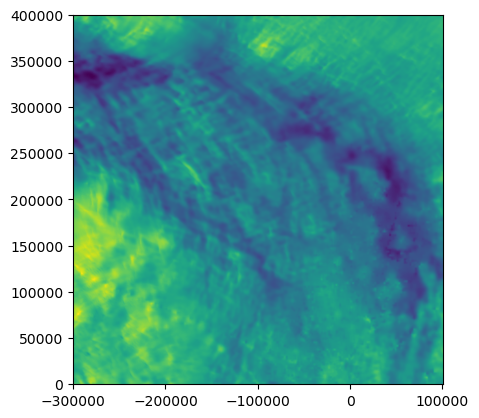

In [293]:
plt.imshow(bed_i, extent = bounds)

In [294]:
bed_count, bed_count_bedmach, bed_count_ifpa

(847, 529, 1124)

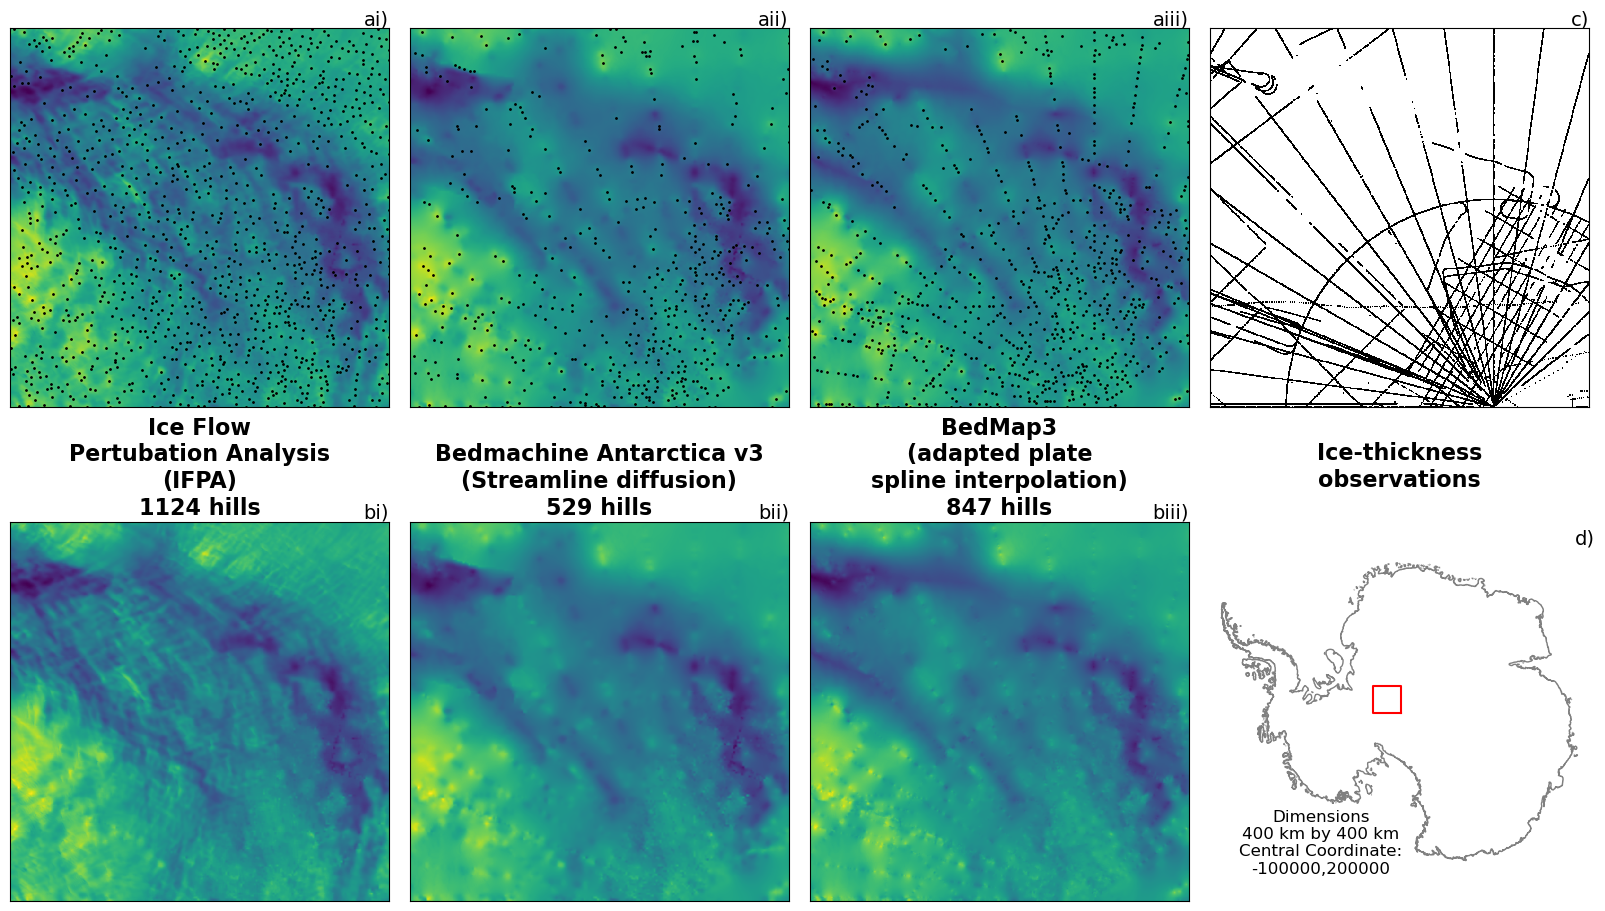

In [295]:
fig = plt.figure(constrained_layout=True, figsize = (16,9))
widths = [4,4,4,4]
heights = [4,4]
gs = fig.add_gridspec(2,4, width_ratios = widths, height_ratios = heights)
ax = [[],[],[],[],[],[],[],[],[],[],[],[]]
ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[1, 0])
ax[2] = fig.add_subplot(gs[0, 1])
ax[3] = fig.add_subplot(gs[1,1])
ax[4] = fig.add_subplot(gs[0,2])
ax[5] = fig.add_subplot(gs[1,2])
ax[6] = fig.add_subplot(gs[0,3])
ax[7] = fig.add_subplot(gs[1,3])

titles = ['Ice Flow\nPertubation Analysis\n(IFPA)\n{} hills'.format(bed_count_ifpa), 
          'Bedmachine Antarctica v3\n(Streamline diffusion)\n{} hills'.format(bed_count_bedmach),\
          'BedMap3\n(adapted plate\nspline interpolation)\n{} hills'.format(bed_count),\
          'Ice-thickness\nobservations\n\n']
labels = ['ai)', 'bi)', 'aii)', 'bii)', 'aiii)', 'biii)', 'c)', 'd)']

im = ax[6].pcolor(X2, Y2, radar, cmap = 'Greys')
im.set_clim(0.99,1)

for i in range(8):
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    ax[i].annotate(labels[i], xy = (1,1), xytext = (1,1), xycoords = 'axes fraction', va = 'bottom', ha = 'right', fontsize = 14)
for i in (0,1,2,3,4,5,6):
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])
for i in range(4):
    ax[i*2+1].set_title(titles[i], fontweight ='bold', fontsize = 16)

ax[7].axis('off');
geom = box(bounds[0], bounds[2], bounds[1], bounds[3])
ax[7].plot(*geom.exterior.xy, color = 'red')

x_width  = (bounds[1] - bounds[0])/1000
y_width =  (bounds[3] - bounds[2])/1000
ax[7].annotate('Dimensions\n{:.0f} km by {:.0f} km\nCentral Coordinate:\n{:.0f},{:.0f}'.format(x_width, y_width, \
                                                                                       centre_coord[0], centre_coord[1]), \
               xy=(2, 1), xytext=(0.3, 0.1), xycoords = 'axes fraction', fontsize = 12, ha = 'center', va = 'center');

ax[4].pcolor(X2, Y2, bed, alpha = 0.5)
ax[5].pcolor(X2, Y2, bed)
for i in range(len(x)):
    ax[4].scatter(X2[0,int(x[i])],Y2[int(y[i]),0], color = 'k', s = 1)

ax[2].pcolor(X_bedmach, Y_bedmach, bedmach, alpha = 0.5)
ax[3].pcolor(X_bedmach, Y_bedmach, bedmach)
for i in range(len(x_mach)):
    ax[2].scatter(X_bedmach[0,int(x_mach[i])],Y_bedmach[int(y_mach[i]),0], color = 'k', s = 1)

ax[0].pcolor(X_bedmach, Y_bedmach, bed_i, alpha  = 0.5)
ax[1].pcolor(X_bedmach, Y_bedmach, bed_i)
for i in range(len(x_ifpa2)):
    ax[0].scatter(X_bedmach[0,int(x_ifpa2[i])],Y_bedmach[int(y_ifpa2[i]),0], color = 'k', s = 1)

#fig.savefig(figures_folder+ 'Bumpiness_bedmap.jpg', bbox_inches = 'tight', dpi = 200)

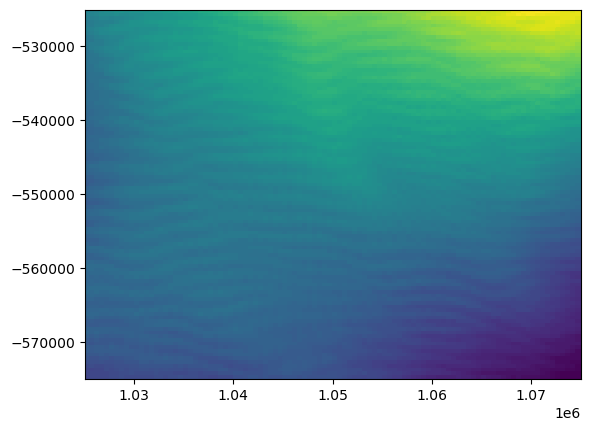

In [40]:
import matplotlib.pyplot as plt
plt.pcolor(X2, Y2, bed)

In [51]:
for i in range(len(x_ifpa)):
#for i in range(20):
    bounds = [x_ifpa[i] - 25200, x_ifpa[i] + 25200, y_ifpa[i] -25200, y_ifpa[i] +25200]
    # Import the bedmap3 data in this region 
    fh = Dataset(filepath_bedmap3, 'r', format = 'NETCDF4');
    X = fh.variables['x'][:]
    Y = fh.variables['y'][:]
    xl = next(x for x, val in enumerate(X) if val >= bounds[0]) # X in ascending order
    xh = next(x for x, val in enumerate(X) if val >= bounds[1])
    yl = next(x for x, val in enumerate(Y) if val <= bounds[2])  # Y in descending order
    yh = next(x for x, val in enumerate(Y) if val <= bounds[3])  
    #print(xl,xh,yl,yh)
    bed = fh.variables['bed_topography'][yh:yl, xl:xh]
    X2 = fh.variables['x'][xl:xh]
    Y2 = fh.variables['y'][yh:yl]
    X2, Y2 = np.meshgrid(np.array(X2), np.array(Y2))
    fh.close()

    bedmap3_b1_5km[i] = PSD_smoothed(bed, X2, Y2, 5000)
    bedmap3_count_max_50[i] = bumpiness_bedmap3(bed, 50)

    if np.mod(i,100) == 99 or i == len(filepaths)-1 or i == 0:
        # Save the metrics produced to file
        NC_data_1D(fpath_metrics + 'bedmap3_b1_5km.nc', bedmap3_b1_5km)
        NC_data_1D(fpath_metrics + 'bedmap3_count_max_50.nc', bedmap3_count_max_50)
        print(i+1, 'out of', len(filepaths), 'processed', 'Last save:', i+1, 'NOW SAVING!!!!!!', end = '\r')
    else:
        print(i+1, 'out of', len(filepaths), 'processed', 'Last save:', i - np.mod(i,100) +1, '           ', end = '\r')

In [52]:
NC_data_1D(fpath_metrics + 'bedmap3_b1_5km.nc', bedmap3_b1_5km)
NC_data_1D(fpath_metrics + 'bedmap3_count_max_50.nc', bedmap3_count_max_50)

In [86]:
X_bedmach[2]

NameError: name 'X_bedmach' is not defined

In [83]:
X[1] - X[0]

np.float32(500.0)

In [68]:
fh = Dataset(filepath_bedmap3, 'r', format = 'NETCDF4');
X = fh.variables['x'][:]
Y = fh.variables['y'][:]
thickness_survey_count = fh.variables['thickness_survey_count'][:,:]
fh.close()

In [75]:
thickness_survey_count.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

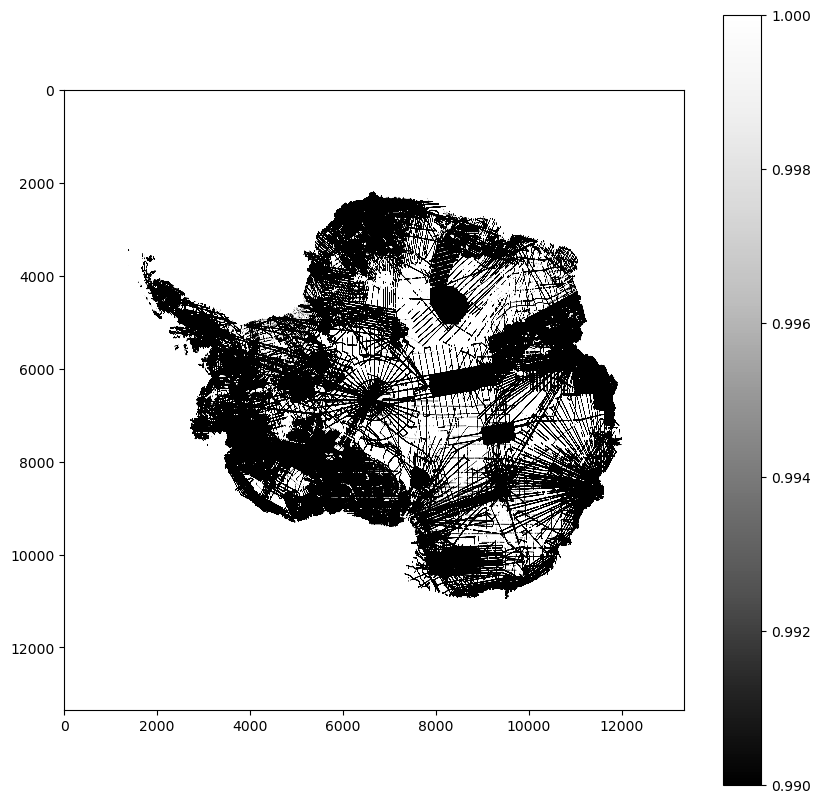

In [91]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
im = plt.imshow(thickness_survey_count.mask, cmap = 'Greys_r')
plt.colorbar()
im.set_clim(0.99,1)


In [7]:
%%time

for i in range(len(x_ifpa)):
#for i in range(20):
    bounds = [x_ifpa[i] - 25200, x_ifpa[i] + 25200, y_ifpa[i] -25200, y_ifpa[i] +25200]
    # Import the ITSLIVE, REMA and Bedmachine data
    _, _, _, _, _, _, _, X_bedmach, Y_bedmach, thick, bedmach, _, _ = \
    smooth_data_load(bounds, filepath_itslive, filepath_rema, filepath_bedmach)
    # Import the ITSLIVE, REMA and Bedmachine data
    _, _, _, _, _, _, _, X_bedmach, Y_bedmach, _, bed_i, _, _ = \
    smooth_data_load(bounds, filepath_itslive, filepath_rema, filepath_bedmach_new)
    # Elevation/hypsometry parameters
    ifpa_mean[i], ifpa_std[i], ifpa_std_deslope[i], ifpa_rms_slope[i], \
        ifpa_rms_curvature[i] = hypso2_analysis(bed_i)
    bedmach_mean[i], bedmach_std[i], bedmach_std_deslope[i], bedmach_rms_slope[i], \
        bedmach_rms_curvature[i] = hypso2_analysis(bedmach)
    ifpa_relief[i], ifpa_elevskew[i], ifpa_kurtosis[i] = hypso_analysis(bed_i)
    bedmach_relief[i], bedmach_elevskew[i], bedmach_kurtosis[i] = hypso_analysis(bedmach)
    # Calculate the low and high frequency metrics for each bed topography 
    ifpa_rms_slope_h[i], ifpa_rms_curv_h[i], ifpa_std_h[i], \
    ifpa_rms_slope_l[i], ifpa_rms_curv_l[i], ifpa_std_l[i] = \
           bandpass_analysis(bed_i)
    bedmach_rms_slope_h[i], bedmach_rms_curv_h[i], bedmach_std_h[i], \
    bedmach_rms_slope_l[i], bedmach_rms_curv_l[i], bedmach_std_l[i] = \
           bandpass_analysis(bedmach)
    # Calculate the fractal dimension metrics for each bed topography 
    ifpa_b1_5km[i] = PSD_smoothed(bed_i, X_bedmach, Y_bedmach, 5000)
    ifpa_b1_thickness[i] = PSD_smoothed(bed_i, X_bedmach, Y_bedmach, np.nanmean(thick))
    bedmach_b1_5km[i] = PSD_smoothed(bedmach, X_bedmach, Y_bedmach, 5000)
    bedmach_b1_thickness[i] = PSD_smoothed(bedmach, X_bedmach, Y_bedmach, np.nanmean(thick))
    P_psd_bedmach, j_bedmach, theta_bedmach = power_spectral_density(bedmach, X_bedmach, Y_bedmach)
    P_psd_ifpa, j_ifpa, theta_ifpa = power_spectral_density(bed_i, X_bedmach, Y_bedmach)
    bedmach_wav_max_power[i], bedmach_theta_max_power[i] = \
            frequency_regression(P_psd_bedmach, j_bedmach, theta_bedmach)
    ifpa_wav_max_power[i], ifpa_theta_max_power[i] = \
            frequency_regression(P_psd_ifpa, j_ifpa, theta_ifpa)
    # Calculate the bumpiness metrics for each bed topography 
    ifpa_count_max_20[i], bedmach_count_max_20[i] = bumpiness(bed_i, bedmach, 20)
    ifpa_count_max_50[i], bedmach_count_max_50[i] = bumpiness(bed_i, bedmach, 50)
    ifpa_count_max_100[i], bedmach_count_max_100[i] = bumpiness(bed_i, bedmach, 100)
    ifpa_count_max_250[i], bedmach_count_max_250[i] = bumpiness(bed_i, bedmach, 250)
    # Update terminal on progress
    #print(i+1, 'out of', len(filepaths), 'processed', end = '\r')
    if np.mod(i,100) == 99 or i == len(filepaths)-1 or i == 0:
        # Save the metrics produced to file
        NC_data_1D(fpath_metrics + 'x_ifpa.nc', x_ifpa)
        NC_data_1D(fpath_metrics + 'y_ifpa.nc', y_ifpa)
        # Elevation/Hypsometry
        NC_data_1D(fpath_metrics + 'ifpa_mean.nc', ifpa_mean)
        NC_data_1D(fpath_metrics + 'ifpa_std.nc', ifpa_std)
        NC_data_1D(fpath_metrics + 'ifpa_std_deslope.nc', ifpa_std_deslope)
        NC_data_1D(fpath_metrics + 'ifpa_rms_slope.nc', ifpa_rms_slope)
        NC_data_1D(fpath_metrics + 'ifpa_rms_curvature.nc', ifpa_rms_curvature)
        NC_data_1D(fpath_metrics + 'ifpa_relief.nc', ifpa_relief)
        NC_data_1D(fpath_metrics + 'ifpa_elevskew.nc', ifpa_elevskew)
        NC_data_1D(fpath_metrics + 'ifpa_kurtosis.nc', ifpa_kurtosis)
        NC_data_1D(fpath_metrics + 'bedmach_mean.nc', bedmach_mean)
        NC_data_1D(fpath_metrics + 'bedmach_std.nc', bedmach_std)
        NC_data_1D(fpath_metrics + 'bedmach_std_deslope.nc', bedmach_std_deslope)
        NC_data_1D(fpath_metrics + 'bedmach_rms_slope.nc', bedmach_rms_slope)
        NC_data_1D(fpath_metrics + 'bedmach_rms_curvature.nc', bedmach_rms_curvature)
        NC_data_1D(fpath_metrics + 'bedmach_relief.nc', bedmach_relief)
        NC_data_1D(fpath_metrics + 'bedmach_elevskew.nc', bedmach_elevskew)
        NC_data_1D(fpath_metrics + 'bedmach_kurtosis.nc', bedmach_kurtosis)
        # Bandpass filtered topography
        NC_data_1D(fpath_metrics + 'i_rms_slope_h.nc', ifpa_rms_slope_h)
        NC_data_1D(fpath_metrics + 'i_rms_curv_h.nc', ifpa_rms_curv_h) 
        NC_data_1D(fpath_metrics + 'i_std_h.nc', ifpa_std_h)
        NC_data_1D(fpath_metrics + 'i_rms_slope_l.nc', ifpa_rms_slope_l) 
        NC_data_1D(fpath_metrics + 'i_rms_curv_l.nc', ifpa_rms_curv_l) 
        NC_data_1D(fpath_metrics + 'i_std_l.nc', ifpa_std_l)
        NC_data_1D(fpath_metrics + 'b_rms_slope_h.nc', bedmach_rms_slope_h) 
        NC_data_1D(fpath_metrics + 'b_rms_curv_h.nc', bedmach_rms_curv_h) 
        NC_data_1D(fpath_metrics + 'b_std_h.nc', bedmach_std_h) 
        NC_data_1D(fpath_metrics + 'b_rms_slope_l.nc', bedmach_rms_slope_l) 
        NC_data_1D(fpath_metrics + 'b_rms_curv_l.nc', bedmach_rms_curv_l) 
        NC_data_1D(fpath_metrics + 'b_std_l.nc', bedmach_std_l)
        # Spectral characteristics
        NC_data_1D(fpath_metrics + 'ifpa_b1_5km.nc', ifpa_b1_5km)
        NC_data_1D(fpath_metrics + 'ifpa_b1_thickness.nc', ifpa_b1_thickness)
        NC_data_1D(fpath_metrics + 'ifpa_wav_max_power.nc', ifpa_wav_max_power)
        NC_data_1D(fpath_metrics + 'ifpa_theta_max_power.nc', ifpa_theta_max_power)
        NC_data_1D(fpath_metrics + 'bedmach_wav_max_power.nc', bedmach_wav_max_power)
        NC_data_1D(fpath_metrics + 'bedmach_theta_max_power.nc', bedmach_theta_max_power)
        NC_data_1D(fpath_metrics + 'bedmach_b1_5km.nc', bedmach_b1_5km)
        NC_data_1D(fpath_metrics + 'bedmach_b1_thickness.nc', bedmach_b1_thickness)
        # Bumpiness 
        NC_data_1D(fpath_metrics + 'ifpa_count_max_20.nc', ifpa_count_max_20)       
        NC_data_1D(fpath_metrics + 'ifpa_count_max_50.nc', ifpa_count_max_50)       
        NC_data_1D(fpath_metrics + 'ifpa_count_max_100.nc', ifpa_count_max_100)       
        NC_data_1D(fpath_metrics + 'ifpa_count_max_250.nc', ifpa_count_max_250)       
        NC_data_1D(fpath_metrics + 'bedmach_count_max_20.nc', bedmach_count_max_20)       
        NC_data_1D(fpath_metrics + 'bedmach_count_max_50.nc', bedmach_count_max_50)       
        NC_data_1D(fpath_metrics + 'bedmach_count_max_100.nc', bedmach_count_max_100)       
        NC_data_1D(fpath_metrics + 'bedmach_count_max_250.nc', bedmach_count_max_250)       
        # Update terminal on progress
        print(i+1, 'out of', len(filepaths), 'processed', 'Last save:', i+1, 'NOW SAVING!!!!!!', end = '\r')
    else:
        print(i+1, 'out of', len(filepaths), 'processed', 'Last save:', i - np.mod(i,100) +1, end = '\r')

CPU times: user 1h 16min 12s, sys: 5min 4s, total: 1h 21min 16s
Wall time: 2d 18h 10min 51s


In [8]:
# Save the metrics produced to file
NC_data_1D(fpath_metrics + 'x_ifpa.nc', x_ifpa)
NC_data_1D(fpath_metrics + 'y_ifpa.nc', y_ifpa)
# Elevation/Hypsometry
NC_data_1D(fpath_metrics + 'ifpa_mean.nc', ifpa_mean)
NC_data_1D(fpath_metrics + 'ifpa_std.nc', ifpa_std)
NC_data_1D(fpath_metrics + 'ifpa_std_deslope.nc', ifpa_std_deslope)
NC_data_1D(fpath_metrics + 'ifpa_rms_slope.nc', ifpa_rms_slope)
NC_data_1D(fpath_metrics + 'ifpa_rms_curvature.nc', ifpa_rms_curvature)
NC_data_1D(fpath_metrics + 'ifpa_relief.nc', ifpa_relief)
NC_data_1D(fpath_metrics + 'ifpa_elevskew.nc', ifpa_elevskew)
NC_data_1D(fpath_metrics + 'ifpa_kurtosis.nc', ifpa_kurtosis)
NC_data_1D(fpath_metrics + 'bedmach_mean.nc', bedmach_mean)
NC_data_1D(fpath_metrics + 'bedmach_std.nc', bedmach_std)
NC_data_1D(fpath_metrics + 'bedmach_std_deslope.nc', bedmach_std_deslope)
NC_data_1D(fpath_metrics + 'bedmach_rms_slope.nc', bedmach_rms_slope)
NC_data_1D(fpath_metrics + 'bedmach_rms_curvature.nc', bedmach_rms_curvature)
NC_data_1D(fpath_metrics + 'bedmach_relief.nc', bedmach_relief)
NC_data_1D(fpath_metrics + 'bedmach_elevskew.nc', bedmach_elevskew)
NC_data_1D(fpath_metrics + 'bedmach_kurtosis.nc', bedmach_kurtosis)
# Bandpass filtered topography
NC_data_1D(fpath_metrics + 'i_rms_slope_h.nc', ifpa_rms_slope_h)
NC_data_1D(fpath_metrics + 'i_rms_curv_h.nc', ifpa_rms_curv_h) 
NC_data_1D(fpath_metrics + 'i_std_h.nc', ifpa_std_h)
NC_data_1D(fpath_metrics + 'i_rms_slope_l.nc', ifpa_rms_slope_l) 
NC_data_1D(fpath_metrics + 'i_rms_curv_l.nc', ifpa_rms_curv_l) 
NC_data_1D(fpath_metrics + 'i_std_l.nc', ifpa_std_l)
NC_data_1D(fpath_metrics + 'b_rms_slope_h.nc', bedmach_rms_slope_h) 
NC_data_1D(fpath_metrics + 'b_rms_curv_h.nc', bedmach_rms_curv_h) 
NC_data_1D(fpath_metrics + 'b_std_h.nc', bedmach_std_h) 
NC_data_1D(fpath_metrics + 'b_rms_slope_l.nc', bedmach_rms_slope_l) 
NC_data_1D(fpath_metrics + 'b_rms_curv_l.nc', bedmach_rms_curv_l) 
NC_data_1D(fpath_metrics + 'b_std_l.nc', bedmach_std_l)
# Spectral characteristics
NC_data_1D(fpath_metrics + 'ifpa_b1_5km.nc', ifpa_b1_5km)
NC_data_1D(fpath_metrics + 'ifpa_b1_thickness.nc', ifpa_b1_thickness)
NC_data_1D(fpath_metrics + 'ifpa_wav_max_power.nc', ifpa_wav_max_power)
NC_data_1D(fpath_metrics + 'ifpa_theta_max_power.nc', ifpa_theta_max_power)
NC_data_1D(fpath_metrics + 'bedmach_wav_max_power.nc', bedmach_wav_max_power)
NC_data_1D(fpath_metrics + 'bedmach_theta_max_power.nc', bedmach_theta_max_power)
NC_data_1D(fpath_metrics + 'bedmach_b1_5km.nc', bedmach_b1_5km)
NC_data_1D(fpath_metrics + 'bedmach_b1_thickness.nc', bedmach_b1_thickness)
# Bumpiness 
NC_data_1D(fpath_metrics + 'ifpa_count_max_20.nc', ifpa_count_max_20)       
NC_data_1D(fpath_metrics + 'ifpa_count_max_50.nc', ifpa_count_max_50)       
NC_data_1D(fpath_metrics + 'ifpa_count_max_100.nc', ifpa_count_max_100)       
NC_data_1D(fpath_metrics + 'ifpa_count_max_250.nc', ifpa_count_max_250)       
NC_data_1D(fpath_metrics + 'bedmach_count_max_20.nc', bedmach_count_max_20)       
NC_data_1D(fpath_metrics + 'bedmach_count_max_50.nc', bedmach_count_max_50)       
NC_data_1D(fpath_metrics + 'bedmach_count_max_100.nc', bedmach_count_max_100)       
NC_data_1D(fpath_metrics + 'bedmach_count_max_250.nc', bedmach_count_max_250)       
# Print message
print("Data written to file")

Data written to file
